# Zadanie nr 5 - metryki w przestrzeni napisów

In [93]:
from collections import Counter
from itertools import product
import sklearn.cluster
from math import inf
import numpy as np
import matplotlib.pyplot as plt

## 1. Metryki

<i>1. Zaimplementuj przynajmniej 3 metryki spośród wymienionych: cosinusowa, LCS, DICE, euklidesowa.</i>

* lcs

In [2]:
def lcs(x, y):
    common = [[0 for _ in range(len(y)+1)] for _ in range(len(x)+1)]
    max_lcs = 0

    for i in range(1, len(x) + 1):
        for j in range(1, len(y)+1):
            common[i][j] = common[i-1][j-1] + 1 if x[i-1] == y[j-1] else 0
            max_lcs = max(max_lcs, common[i][j])

    return 1 - max_lcs/max(len(x), len(y))

#### ngramy

In [3]:
def ngram(x, n):
    ngrams = [x[i:i+n] for i in range(len(x)-n+1)]
    return Counter(ngrams)

* Sorensena-Dice'a

In [8]:
def dice(x, y, n=2):
    ngrams_x, ngrams_y = set(ngram(x, n).keys()), set(ngram(y, n).keys())
    return 1 - 2*len(ngrams_x & ngrams_y)/(len(ngrams_x)+len(ngrams_y))

* euklidesowa

In [9]:
def euclides(x, y):
    ngrams_x, ngrams_y = ngram(x, 2), ngram(y, 2)

    keys = set(ngrams_x.keys()) | set(ngrams_y.keys())
    dist = 0

    for key in keys:
        value_x = ngrams_x.get(key, 0)/len(ngrams_x)
        value_y = ngrams_y.get(key, 0)/len(ngrams_y)

        dist += (value_x - value_y)**2

    return dist**0.5

* Levensheita

In [10]:
def levensheit(x, y):
    edit = [[None for _ in range(len(y) + 1)]
            for _ in range(len(x) + 1)]

    def delta(char_a, char_b): return 0 if char_a == char_b else 1

    for i in range(len(x) + 1):
        edit[i][0] = i

    for j in range(1, len(y) + 1):
        edit[0][j] = j

    for i in range(1, len(x)+1):
        for j in range(1, len(y)+1):
            edit[i][j] = min(edit[i-1][j] + 1, edit[i][j-1] + 1,
                       edit[i-1][j-1] + delta(x[i-1], y[j-1]))

    return edit[len(x)][len(y)]/max(len(x), len(y))

In [14]:
x = 'BCDF'
y = 'ABCDEF'

print('lcs: ', lcs(x, y))
print('dice: ', dice(x, y))
print('euclides: ', euclides(x, y))
print('levensheit: ', levensheit(x, y))

lcs:  0.5
dice:  0.5
euclides:  0.5163977794943222
levensheit:  0.3333333333333333


## 2. Sposoby oceny jakości klasteryzacji

<i>2. Zaimplementuj przynajmniej 2 sposoby oceny jakości klasteryzacji (np. indeks Daviesa-Bouldina).</i>

In [15]:
def sigma(cluster, metric):
    sum_ = 0
    n = len(cluster)
    if n == 1:
        return 0
    
    for i, text_i in enumerate(cluster):
        for text_j in cluster[i+1:]:
                sum_ += metric(text_i, text_j)
                
    return sum_ / (n*(n-1)/2)

def d(cluster_a, cluster_b, metric):
    sum_ = 0
    
    for text_a in cluster_a:
        for text_b in cluster_b:
            sum_ += metric(text_a, text_b)
    
    return sum_/(len(cluster_a)*len(cluster_b))

def d_prim(cluster, metric):
    max_ = 0
    n = len(cluster)
    if n == 1:
        return 0
    
    for i, text_i in enumerate(cluster):
        for text_j in cluster[i+1:]:
                max_ = max(max_, metric(text_i, text_j))
                
    return max_

In [17]:
def davies_bouldin(clusters, metric):
    db = 0
    sigmas = [sigma(cluster, metric) for cluster in clusters]
    
    for i, cluster_i in enumerate(clusters):
        max_ = 0
        for j, cluster_j in enumerate(clusters[i+1:]):
            max_ = max(max_, (sigmas[i] + sigmas[j])/d(cluster_i, cluster_j, metric))
        db += max_
        
    return db/len(clusters)        

In [18]:
def dunn(clusters, metric):
    min_dist = min((d(cluster_a, cluster_b, metric) for cluster_a in clusters for cluster_b in clusters if cluster_a != cluster_b))
    max_size = max((d_prim(cluster, metric) for cluster in clusters))
    return min_dist/max_size

## 3. Stoplista

<i>3. Stwórz stoplistę najczęściej występujących słów. </i>

In [19]:
def get_most_common_words(lines, num):
    word_count = Counter(word for line in lines for word in line.split(' '))
    word_count = list(word_count.items())
    word_count.sort(key=lambda x: x[1], reverse=True)
    return [word[0] for word in word_count[:num]]

In [73]:
def remove_common(lines, num):
    common = get_most_common_words(lines, num)
    return [' '.join([word for word in line.split(' ') if word not in common]) for line in lines], common

## 4. Klasteryzacja

<i>4. Wykonaj klasteryzację zawartości załączonego pliku (lines.txt) przy użyciu przynajmniej 2 algorytmów oraz metryk zaimplementowanych w pkt. 1. i metryki Levenshteina. Każda linia to adres pocztowy firmy, różne sposoby zapisu tego samego adresu powinny się znaleźć w jednym klastrze. </i>

In [58]:
def cluster(texts, metric):
    distances = [[metric(texts[i], texts[j]) for i in range(len(texts))] for j in range(len(texts))]
    clustering = sklearn.cluster.DBSCAN(eps=0.23, min_samples=1).fit(distances)
    return clustering.labels_

## 5. Testy

<i> 5. Porównaj jakość wyników sposobami zaimplementowanymi w pkt. 2. </i>

#### odczytanie danych testowych

Z uwagi na duży czas działania programu, korzystam tylko z 200 pierwszych linijek. Dzięki temu najwolniejsze metody nie działają dłużej niż 2 minuty.

In [59]:
def get_example_lines(num):
    with open('lines.txt', 'r') as file:
        lines = list(file)
        
    lines = lines[:num]

    with open('clusters.txt', 'r') as file:
        clusters = list(file)
    
    correct_clustering = []
    cluster_num = 0
    
    for line in lines:
        cluster = 0
        for cluster_line in clusters:
            if cluster_line[0] == '#':
                cluster += 1
            elif cluster_line == line:
                correct_clustering.append(cluster)
                break
    
    return lines, np.array(correct_clustering)

In [60]:
lines, correct_labels = get_example_lines(200)

#### testy krok po kroku

* klasteryzacja - znalezienie listy z indeksami klastrów poszczególnych linii danych:

In [61]:
labels = cluster(lines, euclides)

In [62]:
print(labels)

[ 0  1  2  2  3  4  5  6  4  7  8  9 10 10 10 10 10 10 10 11 11 12 13 14
  8  4 15 16 16  4  4  4 17 17 18 19  4  4  4 20  7 21  4  4 22 23  4 24
 25 25  4  4  4  4 26 27 26 27 28 28 28 28 28 28 10 10 10  4  4  4  4 29
 30 31 32 33  4  4  4 14 34 35  4 36 36 37  4  7  2  4 38 39  4 40  4 40
 41 41 41 41 41 41 42  3  3  3  3  3 43  3  3 44  3  3  4 45 46 46 46 47
 48 49  4  4 50  4 51 52 53  4 13  4 54  4  4 55  4  4  4  4 56  4 57 57
 57 57 58 58 57 59 60  6  6 61 62  4 57 57  4  4 63  4  4 64 64 64  4  4
 65 66 67 68 69 70 71 71 71 71 71 71 71 34 72 73 73 73 74 74 74 74 75  7
  7  7 76 77 78  8 79 80]


In [63]:
def renumber_labels(labels):
    seen = {}
    current = 0
    new_labels = []
    for label in labels:
        if label in seen:
            new_labels.append(seen[label])
        else:
            new_labels.append(current)
            seen[label] = current
            current += 1
    
    return np.array(new_labels)

In [65]:
print(renumber_labels(correct_labels))

[  0   1   2   2   3   4   5   6   7   8   9  10  11  11  11  11  11  11
  11  12  12  13  14  14  15  16  17  18  18  19  20  21  22  22  23  24
  25  26  27  28  29  29  30  31  32  33  34  35  36  36  37  38  38  38
  39  39  39  39  40  40  40  40  40  40  41  41  41  42  42  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  56  57  58  59   2  60
  61  62  63  64  63  64  65  65  65  65  65  66  67   3   3   3   3   3
   3   3   3   3   3   3  68  69  70  70  70  71  72  73  74  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  89  90  91  27  27
  26  26  26  26  26  92  93   6   6  94  53  95  27  27  26  26  96  91
  91  91  91  91  91  97  98  99  99 100  99 101 102 102 102 102 102 103
 102  53 104 105 105 105 106 106 106 106 106 106 107 107  93 108 109  26
 110 111]


* podzielenie linijek na klastry w postaci zbiorów

In [66]:
def get_clusters_from_labels(lines, labels):
    clusters = {}
    for i, label in enumerate(labels):
        clusters[label] = clusters.get(label, []) + [lines[i]]
        
    return list(clusters.values())

In [67]:
clusters = get_clusters_from_labels(lines, labels)

In [68]:
def print_clustering(clusters):
    for cluster in clusters:
        print('##########')
        for line in cluster:
            print(line)

In [69]:
print_clustering(clusters)

##########
/11692589 RD TUNA CANNERS, LTD. PORTION 1004, SIAR NORTH COAST ROAD, P.O.BOX 2113, MADANG, PAPUA NEW GUINEA

##########
''PA INTERIOR'' LTD BOLSHAYA LUBYANKA STREET, 16/4 MOSCOW, 101000, RUSSIA INN/KPP 7704550148//770801001 495-984-8611

##########
''SSONTEX''  Sp.ZO.O.IMPORT-EXPORTUL:PRZECLAWSKA 5 03-879 WARSZAWA,POLAND NIP 113-01-17-669

''SSONTEX''SP.ZO.O.IMPORT-EXPORT UL:PRZECLAWSKA 5 03-879 WARSZAWA,POLAND NIP 113-01-17-669 TEL./FAX.:0048(022)217 6532--

"SSONTEX" SP.ZO.O IMPORT-EXPORT 03-879 WARSZAWA UL PRZECLAWSKA 5 NIP:113-01-17-669

##########
''TOPEX SP. Z O.O.'' SPOLKA KOMANDYTOWA UL. POGRANICZNA 2/4  02-285 WARSZAWA POLAND

"TOPEX SP.Z.O.O."SP.K. UL.POGRANICZNA 2/4, 02-285 WARSZAWA.POLAND

"TOPEX SP.Z.O.O."SP.K. UL.POGRANICZNA 2/4,02-285 WARSZAWA POLAND

"TOPEX SP.Z O.O."SP.K. UL,POGRANICZNA 2/4 02-285 WARSZAWA

"TOPEX SP.Z O.O."SP.K. UL.POGRANICZNA 2/4,02--285 WARSZAWA

"TOPEX SP. Z O. O." SP. K. UL.POGRANICZNA 2/4,02-285 WARSZAWA,POLAND

"TOPEX SP.Z O.O."SP.K. 

* ocena klasteryzacji, znalezienie wartości obydwu indeksów

In [70]:
print('\tdavies-bouldin index: ', davies_bouldin(clusters, euclides))
print('\t          dunn index: ', dunn(clusters, euclides))

	davies-bouldin index:  0.9019445470324208
	          dunn index:  0.43595297168539265


#### wersja z zastosowaniem stoplisty 

* usunięcie 20 najczęstszych słów

In [74]:
lines_stop, common_words = remove_common(lines, 20)
print('removed words: ', common_words)

removed words:  ['', 'RUSSIA', 'LTD', 'STR.,', 'LLC', 'PETERSBURG,', 'TEL:', '812', '+7', '5', 'SAINT-PETERSBURG,', 'RUSSIA,', 'MOSCOW,', 'STREET,', 'WARSZAWA', 'COMPANY', 'SAINT', 'LIMITED', 'SHIPPING', 'AND']


In [76]:
def show_differences(lines, lines_stop):
    for line, line_stop in zip(lines, lines_stop):
        if line != line_stop:
            print(line)
            print(line_stop, '\n')

* klasteryzacja

In [77]:
labels = cluster(lines_stop, euclides)

In [78]:
print(labels)

[  0   1   2   2   3   4   5   6   4   7   8   9  10  10  10  10  10  10
  10  11  11  12  13  14   8  15  16  17  17   7  18  19  20  20  21  22
   4  23  24  25  26  27  28   4  29  30   4  31  32  32  33  34  35  35
  36  37  36  37  38  38  38  38  38  38  39  40  40   4   4   4  41  42
  43  44  45  46   4   4  47  14  48  49  50  51  51  52  53   7   2  54
  55  56  54  57  54  57  58  58  58  58  58  58  59   3   3   3   3   3
  60   3   3  61   3   3   4  62  63  63  63  64  65  66  67  67  68   4
  69  70  71   4  72   4  73   4  74  75   4  76   4   4  77  41  78  78
  78  78  79  79  78  80  81   6   6  82  83   4  78  78  23  23  84  41
  41  85  85  85  41  86  87  88  89  90  91  92  93  93  93  93  93  93
  93  48  94  95  95  95   7   7  96   7   7   7   7   7  81  97  98   8
  99 100]


* podzielenie linijek na klastry w postaci zbiorów

In [79]:
clusters = get_clusters_from_labels(lines_stop, labels)

In [80]:
def get_clusters_from_labels(lines, labels):
    clusters = {}
    for i, label in enumerate(labels):
        clusters[label] = clusters.get(label, []) + [lines[i]]
        
    return list(clusters.values())

In [81]:
print_clustering(clusters)

##########
/11692589 RD TUNA CANNERS, LTD. PORTION 1004, SIAR NORTH COAST ROAD, P.O.BOX 2113, MADANG, PAPUA NEW GUINEA

##########
''PA INTERIOR'' BOLSHAYA LUBYANKA 16/4 101000, INN/KPP 7704550148//770801001 495-984-8611

##########
''SSONTEX'' Sp.ZO.O.IMPORT-EXPORTUL:PRZECLAWSKA 03-879 WARSZAWA,POLAND NIP 113-01-17-669

''SSONTEX''SP.ZO.O.IMPORT-EXPORT UL:PRZECLAWSKA 03-879 WARSZAWA,POLAND NIP 113-01-17-669 TEL./FAX.:0048(022)217 6532--

"SSONTEX" SP.ZO.O IMPORT-EXPORT 03-879 UL PRZECLAWSKA NIP:113-01-17-669

##########
''TOPEX SP. Z O.O.'' SPOLKA KOMANDYTOWA UL. POGRANICZNA 2/4 02-285 POLAND

"TOPEX SP.Z.O.O."SP.K. UL.POGRANICZNA 2/4, 02-285 WARSZAWA.POLAND

"TOPEX SP.Z.O.O."SP.K. UL.POGRANICZNA 2/4,02-285 POLAND

"TOPEX SP.Z O.O."SP.K. UL,POGRANICZNA 2/4 02-285 WARSZAWA

"TOPEX SP.Z O.O."SP.K. UL.POGRANICZNA 2/4,02--285 WARSZAWA

"TOPEX SP. Z O. O." SP. K. UL.POGRANICZNA 2/4,02-285 WARSZAWA,POLAND

"TOPEX SP.Z O.O."SP.K. UL.POGRANICZNA 2/4 02-285 POLAND

"TOPEX SP. Z O.O." SP.K. UL.

* ocena klasteryzacji, znalezienie wartości obydwu indeksów

In [82]:
print('\tdavies-bouldin index: ', davies_bouldin(clusters, euclides))
print('\t          dunn index: ', dunn(clusters, euclides))

	davies-bouldin index:  0.8872227681822299
	          dunn index:  0.49133743540643143


Wyniki są bardzo porównywalne, ale jednak trochę lepsze, niż w przypadku bez usuwania najczęściej występujących słów.

#### porównanie wyników dla różnych metryk

In [91]:
def test(lines, metric):
    print(metric.__name__)
    labels = cluster(lines, metric)
    clusters = get_clusters_from_labels(lines, labels)
    
    davies_index = davies_bouldin(clusters, metric)
    dunn_index = dunn(clusters, metric)
    print('\tdavies-bouldin index: ', davies_index)
    print('\t          dunn index: ', dunn_index)
    
    return davies_index, dunn_index

In [97]:
def compare_metrics(lines, metrics):
    davies_indices = []
    dunn_indices = []
    
    for metric in metrics:
        davies, dunn = test(lines, metric)
        davies_indices.append(davies)
        dunn_indices.append(dunn)
        
    lines_stop = remove_common(lines, 20)
    print('\n--with stoplist: ')
    
    for metric in metrics:
        davies, dunn = test(lines, metric)
        davies_indices.append(davies)
        dunn_indices.append(dunn)
    
    return davies_indices, dunn_indices

In [98]:
metrics = [dice, levensheit, lcs, euclides]

In [101]:
davies_indices, dunn_indices = compare_metrics(lines, metrics)

dice
	davies-bouldin index:  0.09373961553889651
	          dunn index:  0.4844720496894408
levensheit
	davies-bouldin index:  0.07679842869759863
	          dunn index:  0.742521645021645
lcs
	davies-bouldin index:  0.1426419661368077
	          dunn index:  0.9173553719008266
euclides
	davies-bouldin index:  0.9019445470324208
	          dunn index:  0.43595297168539265

with stoplist: 
dice
	davies-bouldin index:  0.09373961553889651
	          dunn index:  0.4844720496894408
levensheit
	davies-bouldin index:  0.07679842869759863
	          dunn index:  0.742521645021645
lcs
	davies-bouldin index:  0.1426419661368077
	          dunn index:  0.9173553719008266
euclides
	davies-bouldin index:  0.9019445470324208
	          dunn index:  0.43595297168539265


* wzorcowa klasteryzacja z pliku

In [112]:
correct_clustes = get_clusters_from_labels(lines, correct_labels)
davies_index = davies_bouldin(clusters, euclides)
dunn_index = dunn(clusters, euclides)

print('\tdavies-bouldin index: ', davies_index)
print('\t          dunn index: ', dunn_index)
correct_indices = [davies_index, dunn_index]

	davies-bouldin index:  0.8872227681822299
	          dunn index:  0.49133743540643143


In [107]:
def plot_comparison(metrics, davies_indices, dunn_indices):
    fig, ax = plt.subplots(2, 2, figsize=(15,8))
    
    metric_names = list(map(lambda x: x.__name__, metrics))
    
    ax[0][0].bar(metric_names, davies_indices[:len(metrics)], color='coral')
    ax[0][1].bar(metric_names, dunn_indices[:len(metrics)], color='darkblue')
    
    ax[1][0].bar(metric_names, davies_indices[len(metrics):], color='coral')
    ax[1][1].bar(metric_names, dunn_indices[:len(metrics):], color='darkblue')

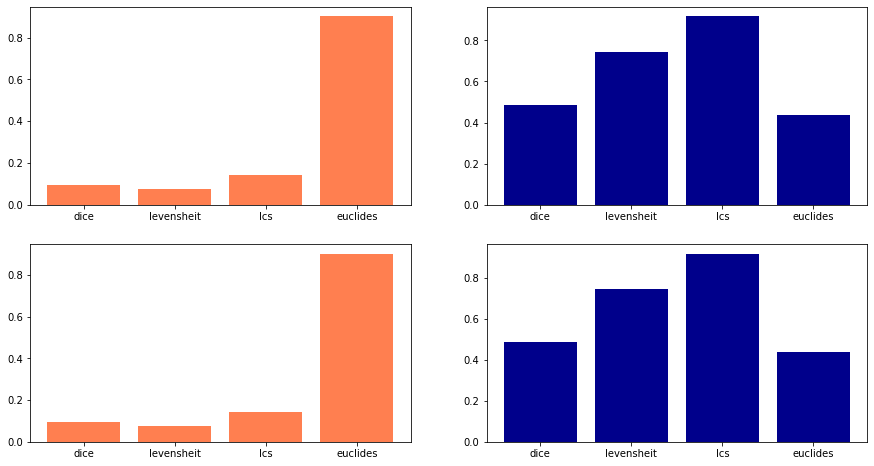

In [108]:
plot_comparison(metrics, davies_indices, dunn_indices)

dunn - więcej -> lepiej <br>
davies-bouldin - mniej -> lepiej

<i>6. Czy masz jakiś pomysł na poprawę jakości klasteryzacji w tym zadaniu? </i>

Sprawozdanie powinno zawierać porównanie wyników wszystkich metryk z użyciem stoplisty i bez.
Można jako wzorcową klasteryzację użyć pliku clusters.txt.

## Wnioski

- skuteczność klasyfikacji zależą od doboru metryki i parametrów dobranych do tejże metryki
- 

M. Hawryluk 20.05.2021